In [1]:
%load_ext autoreload
%autoreload
from IPython.display import clear_output

import os
os.environ["NUMEXPR_NUM_THREADS"] = "1"
os.environ["MKL_NUM_THREADS"] = "1"
os.environ["OMP_NUM_THREADS"] = "1"

import sys
import subprocess
import pdb
import time
import datetime
import math
import random
import _pickle as cPickle
from collections import defaultdict
import matplotlib.pyplot as plt

%matplotlib inline

from six.moves import zip_longest
import numpy as np
import pandas as pd

import tensorflow as tf
from tensorflow import distributions as tfd
from tensorflow.keras.preprocessing.sequence import pad_sequences

from data_structure import get_batches, get_test_batches
from components import tf_log, sample_latents, compute_kl_loss, dynamic_rnn, dynamic_bi_rnn

from topic_beam_search_decoder import BeamSearchDecoder

In [2]:
PAD = '<pad>' # This has a vocab id, which is used to pad the encoder input, decoder input and target sequence
UNK = '<unk>' # This has a vocab id, which is used to represent out-of-vocabulary words
BOS = '<p>' # This has a vocab id, which is used at the beginning of every decoder input sequence
EOS = '</p>' # This has a vocab id, which is used at the end of untruncated target sequences

# load data & set config

In [24]:
def del_all_flags(FLAGS):
    flags_dict = FLAGS._flags()    
    keys_list = [keys for keys in flags_dict]    
    for keys in keys_list:
        FLAGS.__delattr__(keys)

del_all_flags(tf.flags.FLAGS)

flags = tf.app.flags

flags.DEFINE_string('gpu', '2', 'visible gpu')

flags.DEFINE_string('mode', 'train', 'set train or eval')

flags.DEFINE_string('data_path', 'data/synthetic/instances.pkl', 'path of data')
flags.DEFINE_string('modeldir', 'model/topic_vae', 'directory of model')
flags.DEFINE_string('modelname', 'bags', 'name of model')

flags.DEFINE_integer('epochs', 50, 'epochs')
flags.DEFINE_integer('batch_size', 64, 'number of sentences in each batch')
flags.DEFINE_integer('log_period', 1000, 'valid period')

flags.DEFINE_string('opt', 'Adagrad', 'optimizer')
flags.DEFINE_float('lr', 0.01, 'lr')
flags.DEFINE_float('reg', 1., 'regularization term')
flags.DEFINE_float('grad_clip', 5., 'grad_clip')

flags.DEFINE_float('keep_prob', 0.8, 'dropout rate')
flags.DEFINE_float('word_keep_prob', 0.75, 'word dropout rate')

flags.DEFINE_bool('warmup', True, 'flg of warming up')
flags.DEFINE_integer('epochs_cycle', 5, 'number of epochs within a cycle')
flags.DEFINE_float('r_cycle', 0.5, 'proportion used to increase beta within a cycle')
flags.DEFINE_integer('warmup_topic', 0, 'warmup period for KL of topic')

flags.DEFINE_integer('beam_width', 2, 'beam_width')
flags.DEFINE_float('length_penalty_weight', 0.0, 'length_penalty_weight')

flags.DEFINE_integer('n_topic', 20, 'number of topic')
flags.DEFINE_integer('tree_depth', 4, 'number of topic')
flags.DEFINE_integer('dim_hidden_bow', 256, 'dim of hidden bow')
flags.DEFINE_integer('dim_latent_bow', 32, 'dim of latent topic')
flags.DEFINE_integer('dim_emb', 256, 'dim_emb')
flags.DEFINE_integer('dim_hidden', 512, 'dim_hidden')
flags.DEFINE_integer('dim_hidden_topic', 512, 'dim_hidden_topic')
flags.DEFINE_integer('dim_latent', 32, 'dim_latent')
flags.DEFINE_bool('bidirectional', True, 'flg of bidirectional encoding')

# for evaluation
flags.DEFINE_string('refdir', 'ref', 'refdir')
flags.DEFINE_string('outdir', 'out', 'outdir')

flags.DEFINE_string('f', '', 'kernel')
flags.DEFINE_bool('logtostderr', True, 'kernel')
flags.DEFINE_bool('showprefixforinfo', False, '')
flags.DEFINE_bool('verbosity', False, '')
# flags.DEFINE_integer('stderrthreshold', 20, 'kernel')

config = flags.FLAGS

flags.DEFINE_string('modelpath', os.path.join(config.modeldir, config.modelname), 'path of model')

In [25]:
os.environ["CUDA_VISIBLE_DEVICES"] = config.gpu

In [26]:
instances_train, instances_dev, instances_test, word_to_idx, idx_to_word, bow_idxs = cPickle.load(open(config.data_path,'rb'))

In [27]:
def get_batches(instances, batch_size, iterator=False):
    iter_instances = iter(instances)
    n_batch = len(instances)//batch_size
    
    batches = [(i_batch, [next(iter_instances) for i_doc in range(batch_size)]) for i_batch in range(n_batch)]
    
    if iterator: batches = iter(batches)
    return batches

train_batches = get_batches(instances_train, config.batch_size)
dev_batches = get_batches(instances_dev, config.batch_size)
test_batches = get_batches(instances_test, config.batch_size)

In [28]:
flags.DEFINE_integer('n_vocab', len(word_to_idx), 'n_vocab')
flags.DEFINE_integer('dim_bow', len(bow_idxs), 'dim_bow')

flags.DEFINE_integer('cycle_steps', len(train_batches)*config.epochs_cycle, 'number of steps for each cycle')

In [29]:
def debug_shape(variables):
    sample_batch = dev_batches[0][1]
    feed_dict = get_feed_dict(sample_batch)
    _variables = sess.run(variables, feed_dict=feed_dict)
    for _variable, variable in zip(_variables, variables):
        if hasattr(variable, 'name'):
            print(variable.name, ':', _variable.shape)
        else:
            print(_variable.shape)

def debug_value(variables, return_value=False):
    sample_batch = test_batches[0][1]
    feed_dict = get_feed_dict(sample_batch)
    _variables = sess.run(variables, feed_dict=feed_dict)

    if return_value: 
        return _variables
    else:
        for _variable, variable in zip(_variables, variables):
            if hasattr(variable, 'name'):
                print(variable.name, ':', _variable)
            else:
                print(_variable)
                
def check_shape(variables):
    if 'sess' in globals(): raise
    sess = tf.Session()
    sess.run(tf.global_variables_initializer())
    
    sample_batch = test_batches[0][1]
    feed_dict = get_feed_dict(sample_batch)
    _variables = sess.run(variables, feed_dict=feed_dict)
    for _variable, variable in zip(_variables, variables):
        if hasattr(variable, 'name'):
            print(variable.name, ':', _variable.shape)
        else:
            print(_variable.shape)
            
    sess.close()
    
def check_value(variables):
    if 'sess' in globals(): raise
    sess = tf.Session()
    sess.run(tf.global_variables_initializer())
    
    sample_batch = test_batches[0][1]
    feed_dict = get_feed_dict(sample_batch)
    _variables = sess.run(variables, feed_dict=feed_dict)
    for _variable, variable in zip(_variables, variables):
        if hasattr(variable, 'name'):
            print(variable.name, ':', _variable)
        else:
            print(_variable.shape)
            
    sess.close()    

# run model 

## init

In [30]:
def get_feed_dict(batch, mode='train'):
    bow = np.array([instance.bow for instance in batch]).astype(np.float32)
    keep_prob = config.keep_prob if mode == 'train' else 1.0
    feed_dict = {
                t_variables['bow']: bow, 
                t_variables['keep_prob']: keep_prob
    }
    return  feed_dict

In [31]:
tf.reset_default_graph()

t_variables = {}
t_variables['bow'] = tf.placeholder(tf.float32, [None, config.dim_bow])
t_variables['keep_prob'] = tf.placeholder(tf.float32)

# tree_idxs = {0:[1, 2], 
#              1:[10, 11], 2:[20, 21, 22], 
#              10: [100, 101], 11: [110, 111, 112], 20: [200, 201], 21: [210, 211], 22:[220, 221, 222]
#              }

# tree_idxs = {0:[1, 2, 3], 
#                       1:[10, 11], 2:[20, 21], 3:[30, 31]}

tree_idxs = {0:[1, 2, 3], 
              1:[10, 11, 12], 2:[20, 21, 22], 3:[30, 31, 32]}


# tree_idxs = {0:[1, 2, 3], 
#                       1:[10, 11], 2:[20, 21], 3:[30, 31],
#                       10: [100, 101], 11: [110, 111], 20: [200, 201], 21: [210, 211], 30:[300, 301], 31:[310, 311]}

topic_idxs = [0] + [idx for child_idxs in tree_idxs.values() for idx in child_idxs]



## doubly rnn

In [32]:
class DoublyRNNCell:
    def __init__(self, dim_hidden, output_layer=None):
        self.dim_hidden = dim_hidden
        
        self.ancestral_layer=tf.layers.Dense(units=dim_hidden, activation=tf.nn.tanh, name='ancestral')
        self.fraternal_layer=tf.layers.Dense(units=dim_hidden, activation=tf.nn.tanh, name='fraternal')
        self.hidden_layer = tf.layers.Dense(units=dim_hidden, activation=tf.nn.tanh, name='hidden')
        
        self.output_layer=output_layer
        
    def __call__(self, state_ancestral, state_fraternal, reuse=True):
        with tf.variable_scope('input', reuse=reuse):
            state_ancestral = self.ancestral_layer(state_ancestral)
            state_fraternal = self.fraternal_layer(state_fraternal)

        with tf.variable_scope('output', reuse=reuse):
            state_hidden = self.hidden_layer(state_ancestral + state_fraternal)
            if self.output_layer is not None: 
                output = self.output_layer(state_hidden)
            else:
                output = state_hidden
            
        return output, state_hidden
    
    def get_initial_state(self, name):
        initial_state = tf.get_variable(name, [1, self.dim_hidden], dtype=tf.float32)
        return initial_state
    
    def get_zero_state(self, name):
        zero_state = tf.zeros([1, self.dim_hidden], dtype=tf.float32, name=name)
        return zero_state

In [33]:
def doubly_rnn(dim_hidden, tree_idxs, initial_state_parent=None, initial_state_sibling=None, output_layer=None, name=''):
    outputs, states_parent = {}, {}
    
    with tf.variable_scope(name, reuse=False):
        doubly_rnn_cell = DoublyRNNCell(dim_hidden, output_layer)

        if initial_state_parent is None: initial_state_parent = doubly_rnn_cell.get_initial_state('init_state_parent')
        if initial_state_sibling is None: 
#             initial_state_sibling = doubly_rnn_cell.get_initial_state('init_state_sibling')
            initial_state_sibling = doubly_rnn_cell.get_zero_state('init_state_sibling')
        output, state_sibling = doubly_rnn_cell(initial_state_parent, initial_state_sibling, reuse=False)
        outputs[0], states_parent[0] = output, state_sibling

        for parent_idx, child_idxs in tree_idxs.items():
            state_parent = states_parent[parent_idx]
            state_sibling = initial_state_sibling
            for child_idx in child_idxs:
                output, state_sibling = doubly_rnn_cell(state_parent, state_sibling)
                outputs[child_idx], states_parent[child_idx] = output, state_sibling

    return outputs

## stick break

In [34]:
def nCRP(tree_sticks_topic):
    tree_prob_topic = {}
    tree_prob_leaf = {}
    # calculate topic probability and save
    tree_prob_topic[0] = 1.
    
    for parent_idx, child_idxs in tree_idxs.items():
        rest_prob_topic = tree_prob_topic[parent_idx]
        for child_idx in child_idxs:
            stick_topic = tree_sticks_topic[child_idx]
            if child_idx == child_idxs[-1]:
                prob_topic = rest_prob_topic
            else:
                prob_topic = rest_prob_topic * stick_topic
            
            if not child_idx in tree_idxs: # leaf childs
                tree_prob_leaf[child_idx] = prob_topic
            else:
                tree_prob_topic[child_idx] = prob_topic
                
            rest_prob_topic -= prob_topic
            
    return tree_prob_leaf

In [35]:
def get_ancestor_idxs(leaf_idx, ancestor_idxs = None):
    if ancestor_idxs is None: ancestor_idxs = [leaf_idx]
    
    parent_idx = child_to_parent_idxs[leaf_idx]
    ancestor_idxs += [parent_idx]
    if parent_idx in child_to_parent_idxs: get_ancestor_idxs(parent_idx, ancestor_idxs)
    return ancestor_idxs[::-1]

In [36]:
def get_prob_topic(tree_prob_leaf, prob_depth):
    tree_prob_topic = defaultdict(float)
    
    leaf_ancestor_idxs = {leaf_idx: get_ancestor_idxs(leaf_idx) for leaf_idx in tree_prob_leaf}
    for leaf_idx, ancestor_idxs in leaf_ancestor_idxs.items():
        prob_leaf = tree_prob_leaf[leaf_idx]
        for i, ancestor_idx in enumerate(ancestor_idxs):
            prob_ancestor = prob_leaf * tf.expand_dims(prob_depth[:, i], -1)
            tree_prob_topic[ancestor_idx] += prob_ancestor
    prob_topic = tf.concat([tree_prob_topic[topic_idx] for topic_idx in topic_idxs], -1)
    return prob_topic

## build model

In [37]:
def get_tree_topic_bow(tree_topic_embeddings):
    def get_depth(parent_idx=0, tree_depth = None, depth=1):
        if tree_depth is None: tree_depth={0: depth}

        child_idxs = tree_idxs[parent_idx]
        depth +=1
        for child_idx in child_idxs:
            tree_depth[child_idx] = depth
            if child_idx in tree_idxs: get_depth(child_idx, tree_depth, depth)
        return tree_depth
       
    def softmax_with_temperature(logits, axis=None, name=None, temperature=1.):
        if axis is None:
            axis = -1
        return tf.exp(logits / temperature) / tf.reduce_sum(tf.exp(logits / temperature), axis=axis)
    
    tree_depth = get_depth()

    tree_topic_bow = {}
    for topic_idx, depth in tree_depth.items():
        topic_embedding = tree_topic_embeddings[topic_idx]
        temperature = tf.constant(10. ** (1./depth), dtype=tf.float32)
        logits = tf.matmul(topic_embedding, bow_embeddings, transpose_b=True)
        tree_topic_bow[topic_idx] = softmax_with_temperature(logits, axis=-1, temperature=temperature)
    
    return tree_topic_bow

In [38]:
# encode bow
with tf.variable_scope('topic/enc', reuse=False):
    hidden_bow_ = tf.layers.Dense(units=config.dim_hidden_bow, activation=tf.nn.relu, name='hidden_bow')(t_variables['bow'])
    hidden_bow = tf.layers.Dropout(t_variables['keep_prob'])(hidden_bow_)
    means_bow = tf.layers.Dense(units=config.dim_latent_bow, name='mean_bow')(hidden_bow)
    logvars_bow = tf.layers.Dense(units=config.dim_latent_bow, kernel_initializer=tf.constant_initializer(0), bias_initializer=tf.constant_initializer(0), name='logvar_bow')(hidden_bow)
    latents_bow = sample_latents(means_bow, logvars_bow) # sample latent vectors
    prob_layer = lambda h: tf.nn.sigmoid(tf.matmul(latents_bow, h, transpose_b=True))
    
    tree_sticks_topic = doubly_rnn(config.dim_latent_bow, tree_idxs, output_layer=prob_layer, name='sticks_topic')
    tree_prob_leaf = nCRP(tree_sticks_topic)
    prob_depth = tf.layers.Dense(units=config.tree_depth, activation=tf.nn.softmax, name='prob_topic')(latents_bow) # inference of topic probabilities
    
    prob_topic = get_prob_topic(tree_prob_leaf, prob_depth)

# decode bow
with tf.variable_scope('shared', reuse=False):
    embeddings = tf.get_variable('emb', [config.n_vocab, config.dim_emb], dtype=tf.float32, initializer=tf.contrib.layers.xavier_initializer()) # embeddings of vocab

bow_embeddings = tf.nn.embedding_lookup(embeddings, bow_idxs) # embeddings of each bow features

with tf.variable_scope('topic/dec', reuse=False):
    tree_topic_embeddings = doubly_rnn(config.dim_emb, tree_idxs, name='emb_topic')
    tree_topic_bow = get_tree_topic_bow(tree_topic_embeddings) # bow vectors for each topic
    
    topic_bow = tf.concat([tree_topic_bow[topic_idx] for topic_idx in topic_idxs], 0)
    logits_bow = tf_log(tf.matmul(prob_topic, topic_bow)) # predicted bow distribution

## define loss

In [39]:
def get_tree_mask_reg(tree_idxs):
    tree_mask_reg = np.ones([len(topic_idxs), len(topic_idxs)], dtype=np.float32)
    parent_to_descendant_idxs = {parent_idx: get_descendant_idxs(parent_idx) for parent_idx in tree_idxs}
    
    for parent_idx, descendant_idxs in parent_to_descendant_idxs.items():
        for descendant_idx in descendant_idxs:
            tree_mask_reg[topic_idxs.index(parent_idx), topic_idxs.index(descendant_idx)] = tree_mask_reg[topic_idxs.index(descendant_idx), topic_idxs.index(parent_idx)] = 0.
            
    return tree_mask_reg

def get_descendant_idxs(parent_idx, descendant_idxs = None):
    if descendant_idxs is None: descendant_idxs = []
    
    child_idxs = tree_idxs[parent_idx]
    descendant_idxs += child_idxs
    for child_idx in child_idxs:
        if child_idx in tree_idxs: get_descendant_idxs(child_idx, descendant_idxs)
    return descendant_idxs

In [40]:
# define losses
topic_losses_recon = -tf.reduce_sum(tf.multiply(t_variables['bow'], logits_bow), 1)
topic_loss_recon = tf.reduce_mean(topic_losses_recon) # negative log likelihood of each words

topic_loss_kl = compute_kl_loss(means_bow, logvars_bow) # KL divergence b/w latent dist & gaussian std

topic_bow_norm = topic_bow / tf.norm(topic_bow, axis=1, keepdims=True)
topic_dots = tf.clip_by_value(tf.matmul(topic_bow_norm, tf.transpose(topic_bow_norm)), -1., 1.)
# topic_loss_reg = tf.reduce_mean(tf.square(topic_dots - tf.eye(len(topic_idxs))))
tree_mask_reg = get_tree_mask_reg(tree_idxs)
topic_loss_reg = tf.reduce_mean(tf.square(topic_dots - tf.eye(len(topic_idxs))) * tree_mask_reg)

global_step = tf.Variable(0, name='global_step',trainable=False)

loss = topic_loss_recon + topic_loss_kl + config.reg * topic_loss_reg
# loss = topic_loss_recon + topic_loss_kl

# define optimizer
if config.opt == 'Adam':
    optimizer = tf.train.AdamOptimizer(config.lr)
elif config.opt == 'Adagrad':
    optimizer = tf.train.AdagradOptimizer(config.lr)

grad_vars = optimizer.compute_gradients(loss)
clipped_grad_vars = [(tf.clip_by_value(grad, -config.grad_clip, config.grad_clip), var) for grad, var in grad_vars]
opt = optimizer.apply_gradients(clipped_grad_vars, global_step=global_step)

# monitor
n_bow = tf.reduce_sum(t_variables['bow'], 1)
topic_ppls = tf.divide(topic_losses_recon, tf.maximum(1e-5, n_bow))
topics_freq_bow_indices = tf.nn.top_k(topic_bow, 10, name='topic_freq_bow').indices

In [41]:
def get_loss(sess, batches):
    losses = []
    ppl_list = []
    for ct, batch in batches:
        feed_dict = get_feed_dict(batch, mode='test')
        loss_batch, topic_loss_recon_batch, topic_loss_kl_batch, topic_loss_reg_batch, ppls_batch \
            = sess.run([loss, topic_loss_recon, topic_loss_kl, topic_loss_reg, topic_ppls], feed_dict = feed_dict)
        losses += [[loss_batch, topic_loss_recon_batch, topic_loss_kl_batch, topic_loss_reg_batch]]
        ppl_list += list(ppls_batch)
    loss_mean, topic_loss_recon_mean, topic_loss_kl_mean, topic_loss_reg_mean = np.mean(losses, 0)
    ppl_mean = np.exp(np.mean(ppl_list))
    return loss_mean, topic_loss_recon_mean, topic_loss_kl_mean, topic_loss_reg_mean, ppl_mean

In [45]:
from matplotlib.colors import Normalize # Normalizeをimport

def print_topic_sample():
    _topics_bow = sess.run(topic_bow)
    plt.figure(figsize=(3, 4))
    
    _topic_bow = _topics_bow[0]
    plt.subplot(5,3,2)
    plt.axis('off')
    plt.imshow(_topic_bow.reshape(30,30), cmap='Wistia', norm=Normalize(vmin=0., vmax=np.max(_topics_bow)))
    
    for i in range(1, len(topic_idxs)):
        _topic_bow = _topics_bow[i]
        plt.subplot(5,3,i+3)
        plt.axis('off')
        plt.imshow(_topic_bow.reshape(30,30), cmap='Wistia', norm=Normalize(vmin=0., vmax=np.max(_topics_bow)))
        
    plt.show()

In [46]:
if 'sess' in globals(): sess.close()
sess = tf.Session(config=tf.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1))
sess.run(tf.global_variables_initializer())

losses_train = []
ppls_train = []
loss_min = np.inf
beta_eval = 1.
epoch = 0
train_batches = get_batches(instances_train, config.batch_size, iterator=True)
saver = tf.train.Saver(max_to_keep=10)

log_df = pd.DataFrame(columns=pd.MultiIndex.from_tuples(
                    list(zip(*[['','','','TRAIN:','TM','','','','VALID:','TM','','',''],
                            ['Time','Ep','Ct','LOSS','PPL','NLL','KL','REG','LOSS','PPL','NLL','KL','REG']]))))

TRAIN:    TM                      VALID:   TM                 \
     Time Ep Ct    LOSS   PPL     NLL    KL   REG    LOSS  PPL     NLL     KL   
1       1  0  0  720.92  1309  717.72  2.53  0.67  709.40  900  680.25  28.48   
157     1  1  0  683.65   889  679.05  3.94  0.65  680.54  867  676.46   3.46   
313     1  2  0  681.57   873  677.19  3.76  0.62  679.36  860  675.64   3.16   
469     1  3  0  680.63   866  676.40  3.65  0.58  678.38  851  674.63   3.34   
625     1  4  0  680.00   862  675.90  3.57  0.53  677.83  847  674.17   3.29   
781     1  5  0  679.53   859  675.52  3.51  0.50  677.58  846  674.08   3.14   
937     1  6  0  679.15   856  675.22  3.46  0.47  677.15  840  673.35   3.47   
1093    1  7  0  678.83   854  674.96  3.42  0.45  676.88  840  673.37   3.18   
1249    1  8  0  678.57   852  674.74  3.39  0.44  676.69  838  673.12   3.24   
1405    1  9  0  678.34   850  674.56  3.35  0.43  676.73  840  673.35   3.06   

            
       REG  
1     0.67  
157   0.62  
313   0.56  
469   0.41  
625   0.37  
781   0.35  
937   0.34  
1093  0.33  
1249  0.33  
1405  0.32

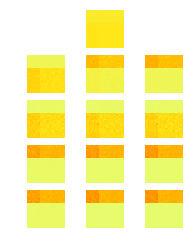

KeyboardInterrupt: 

In [47]:
if len(log_df) == 0:
    cmd_rm = 'rm -r %s' % config.modeldir
    res = subprocess.call(cmd_rm.split())

    cmd_mk = 'mkdir %s' % config.modeldir
    res = subprocess.call(cmd_mk.split())

time_start = time.time()
while epoch < config.epochs:
    for ct, batch in train_batches:
        feed_dict = get_feed_dict(batch)

        _, loss_batch, topic_loss_recon_batch, topic_loss_kl_batch, topic_loss_reg_batch, ppls_batch = \
        sess.run([opt, loss, topic_loss_recon, topic_loss_kl, topic_loss_reg, topic_ppls], feed_dict = feed_dict)
            
        losses_train += [[loss_batch, topic_loss_recon_batch, topic_loss_kl_batch, topic_loss_reg_batch]]
        ppls_train += list(ppls_batch)

        if ct%config.log_period==0:
            loss_train, topic_loss_recon_train, topic_loss_kl_train, topic_loss_reg_train = np.mean(losses_train, 0)
            ppl_train = np.exp(np.mean(ppls_train))
            loss_dev, topic_loss_recon_dev, topic_loss_kl_dev, topic_loss_reg_dev, ppl_dev = get_loss(sess, dev_batches)
            global_step_log = sess.run(tf.train.get_global_step())
            
#             if loss_dev < loss_min:
#                 loss_min = loss_dev
#                 saver.save(sess, config.modelpath, global_step=global_step_log)

            clear_output()
    
            time_log = int(time.time() - time_start)
            log_series = pd.Series([time_log, epoch, ct, \
                    '%.2f'%loss_train, '%.0f'%ppl_train, '%.2f'%topic_loss_recon_train, '%.2f'%topic_loss_kl_train, '%.2f'%topic_loss_reg_train, \
                    '%.2f'%loss_dev, '%.0f'%ppl_dev, '%.2f'%topic_loss_recon_dev, '%.2f'%topic_loss_kl_dev, '%.2f'%topic_loss_reg_dev],
                    index=log_df.columns)
            log_df.loc[global_step_log] = log_series
            display(log_df)
            
            # visualize topicu
            print_topic_sample()

            time_start = time.time()
            
    epoch += 1
    train_batches = get_batches(instances_train, config.batch_size, iterator=True)
    
    
display(log_df)
print_topic_sample()        

# confirm variables

In [24]:
debug_value([prob_depth[4]])

strided_slice:0 : [5.2841981e-03 3.6565879e-01 6.2899369e-01 6.3372136e-05]


In [25]:
debug_value([topic_embeddings[:, :5]])

NameError: name 'topic_embeddings' is not defined

In [ ]:
_topic_bow, = debug_value([topic_bow], return_value=True)

In [ ]:
plt.bar(bow_idxs, topic_bow[0])

In [ ]:
plt.bar(bow_idxs, topic_bow[1])

In [ ]:
plt.bar(bow_idxs, topic_bow[2])

In [ ]:
plt.bar(bow_idxs, topic_bow[4])

In [ ]:
len(bow_idxs)

In [ ]:
debug_value([prob_topic[3]])

In [ ]:
debug_value([tf.exp(-tf.divide(topic_losses_recon, n_bow))])

### test

In [ ]:
debug_shape([bow, hidden_bow, latents_bow, prob_topic, bow_embeddings, topic_embeddings, topic_bow, prob_bow])

In [ ]:
debug_shape([topic_losses_recon, topic_loss_recon, n_bow, ppls, topic_embeddings_norm, tf.expand_dims(topic_angles_mean, -1), topic_angles_vars])

In [ ]:
debug_value([tf.reduce_sum(tf.square(topic_embeddings_norm), 1)], return_value=True)[0]

In [ ]:
debug_value([tf.reduce_sum(prob_topic, -1), tf.reduce_sum(topic_bow, -1), tf.reduce_sum(tf.exp(prob_bow), 1)])

In [ ]:
sigma_bow = tf.exp(0.5 * logvars_bow)
dist_bow = tfd.Normal(means_bow, sigma_bow)
dist_std = tfd.Normal(0., 1.)
topic_loss_kl_tmp = tf.reduce_mean(tf.reduce_sum(tfd.kl_divergence(dist_bow, dist_std), 1))

In [ ]:
debug_value([topic_loss_recon, topic_loss_kl, topic_loss_kl_tmp])

In [ ]:
_logvars, _means, _kl_losses, _latents, _output_logits = sess.run([logvars, means, kl_losses, latents, output_logits], feed_dict=feed_dict)


In [ ]:
_logvars.shape, _means.shape, _kl_losses.shape, _latents.shape

In [ ]:
_output_logits

In [ ]:
_output_logits, _dec_target_idxs_do, _dec_mask_tokens_do, _recon_loss, _kl_losses, _ = sess.run([output_logits, dec_target_idxs_do, dec_mask_tokens_do, recon_loss, kl_losses, opt], feed_dict=feed_dict)


In [ ]:
tf.reduce_max(output_logits, 2).eval(session=sess, feed_dict=feed_dict).shape

In [ ]:
_output_logits.shape, _dec_target_idxs_do.shape, _dec_mask_tokens_do.shape

In [ ]:
_logits = np.exp(_output_logits) / np.sum(np.exp(_output_logits), 2)[:, :, None]

In [ ]:
_idxs = _dec_target_idxs_do

In [ ]:
_losses = np.array([[-np.log(_logits[i, j, _idxs[i, j]]) for j in range(_idxs.shape[1])] for i in range(_idxs.shape[0])]) * _dec_mask_tokens_do

In [ ]:
np.sum(_losses)/np.sum(_dec_mask_tokens_do)

In [ ]:
_recon_loss

In [ ]:
_kl_losses.shape